# MyCobot Objects Gripping And Classification Tasks
## Import necessary libraries

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib as Path
import cv2
import json
import os
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

torch.__version__ 

'2.4.1'

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

## Load Dataset

In [4]:
torch.manual_seed(42)

def load_dataset(dataset_path):
    data = []
     # Loop through each action folder
    for action_folder in os.listdir(dataset_path):
        action_path = os.path.join(dataset_path, action_folder)
        
        # Check if it's a directory
        if os.path.isdir(action_path):
            # Paths to the image and joint_angles.json
            image_path = os.path.join(action_path, "image.png")
            json_path = os.path.join(action_path, "joint_angles.json")
            
            # Load image
            if os.path.exists(image_path):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = cv2.resize(image, dsize=(224, 224))
                image = image / 255.0 
                image = np.transpose(image, (2, 0, 1)) 
                image_tensor = torch.tensor(image, dtype=torch.float32)
            
            # Load joint angles
            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    joint_angles = json.load(f)['actions']
                    joint_angles = [row[:-1] for row in joint_angles]
                    joint_angles_tensor = torch.tensor(joint_angles, dtype=torch.float32) / 180.0
            
            # Append to data list
            data.append((image_tensor, joint_angles_tensor))
    
    return data

Loaded 500 actions.
First Image Shape: torch.Size([3, 224, 224])
First Joint Angles: tensor([[ 0.0216, -0.0298, -0.3086, -0.0307, -0.0181,  0.4127],
        [ 0.0216, -0.2720, -0.3244,  0.2188, -0.0468,  0.4127],
        [ 0.0833, -0.0298, -0.3086, -0.1141, -0.0181,  0.3060],
        [ 0.2944, -0.2778,  0.0000, -0.0722, -0.0181,  0.3060],
        [ 0.0833,  0.0000,  0.0000,  0.0000,  0.0000,  0.3060]])


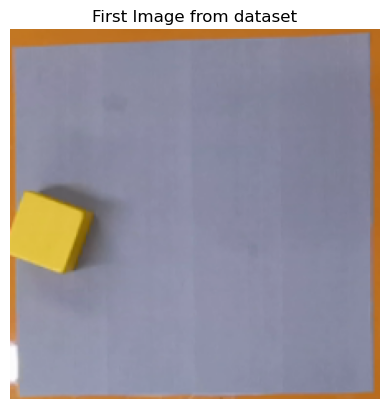

In [5]:
# Load the dataset
dataset_path = "dataset"
data = load_dataset(dataset_path)

# Print dataset information
print(f"Loaded {len(data)} actions.")
print(f"First Image Shape: {data[0][0].shape}")
print(f"First Joint Angles: {data[334][1]}")

# Display the first image
plt.imshow(data[334][0].permute(1, 2, 0))
plt.axis('off')
plt.title("First Image from dataset")
plt.show()

In [6]:
class ActionDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create the dataset
dataset = ActionDataset(data)

## Data Split

Training Dataset Size: 400
Testing Dataset Size: 100
first image shape: torch.Size([3, 224, 224])
first joint angles: tensor([[ 0.1056, -0.0298, -0.3086, -0.0307, -0.0181,  0.5589],
        [ 0.1056, -0.2133, -0.4310,  0.2393, -0.0208,  0.5589],
        [ 0.0833, -0.0298, -0.3086, -0.1141, -0.0181,  0.3060],
        [-0.1167, -0.2500, -0.0586, -0.0585, -0.0181,  0.3893],
        [ 0.0833,  0.0000,  0.0000,  0.0000,  0.0000,  0.3060]])
train dataloader image shape: torch.Size([32, 3, 224, 224])
train dataloader image shape: torch.Size([32, 5, 6])


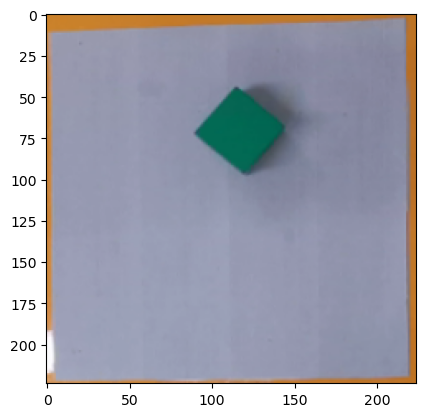

In [7]:
from torch.utils.data import random_split

# Define the split ratio (80% train, 20% test, for example)
train_ratio = 0.8
test_ratio = 0.2
total_size = len(dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")
print(f"first image shape: {test_dataset[0][0].shape}")
print(f"first joint angles: {test_dataset[2][1]}")
plt.imshow(test_dataset[2][0].permute(1, 2, 0))
print(f"train dataloader image shape: {next(iter(train_dataloader))[0].shape}")
print(f"train dataloader image shape: {next(iter(train_dataloader))[1].shape}")

## Create model class

In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Define the model class
class ImageToJointAngles(nn.Module):
    def __init__(self):
        super(ImageToJointAngles, self).__init__()
        # Backbone: Use a pretrained ResNet18 for feature extraction
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer
        
        # Fully connected layers to predict joint angles
        self.fc = nn.Sequential(
            nn.Linear(512, 256),  # ResNet18 outputs 512 features
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 30)  # 5x6 = 30 joint angles
        )
        
    def forward(self, x):
        # Feature extraction
        features = self.resnet(x)
        
        # Fully connected layers
        joint_angles = self.fc(features)
        
        # Reshape output to (batch_size, 5, 6)
        joint_angles = joint_angles.view(-1, 5, 6)
        
        return joint_angles


In [9]:
torch.manual_seed(42)
model= ImageToJointAngles().to(device)
x = torch.randn(32, 3, 224, 224)  # Batch of 32 images
output = model(x.to(device))

print("Output shape:", output.shape)

Output shape: torch.Size([32, 5, 6])


## Pick up the loss function and optimizer

In [10]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Testing Loop

In [11]:


num_epochs = 20
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
    
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")



Epoch 1/20, Train Loss: 0.0098, Test Loss: 0.0063
Epoch 2/20, Train Loss: 0.0025, Test Loss: 0.0031
Epoch 3/20, Train Loss: 0.0020, Test Loss: 0.0026
Epoch 4/20, Train Loss: 0.0018, Test Loss: 0.0025
Epoch 5/20, Train Loss: 0.0016, Test Loss: 0.0016
Epoch 6/20, Train Loss: 0.0012, Test Loss: 0.0012
Epoch 7/20, Train Loss: 0.0009, Test Loss: 0.0012
Epoch 8/20, Train Loss: 0.0008, Test Loss: 0.0011
Epoch 9/20, Train Loss: 0.0006, Test Loss: 0.0008
Epoch 10/20, Train Loss: 0.0005, Test Loss: 0.0010
Epoch 11/20, Train Loss: 0.0006, Test Loss: 0.0008
Epoch 12/20, Train Loss: 0.0005, Test Loss: 0.0012
Epoch 13/20, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 14/20, Train Loss: 0.0007, Test Loss: 0.0010
Epoch 15/20, Train Loss: 0.0007, Test Loss: 0.0010
Epoch 16/20, Train Loss: 0.0006, Test Loss: 0.0010
Epoch 17/20, Train Loss: 0.0004, Test Loss: 0.0008
Epoch 18/20, Train Loss: 0.0004, Test Loss: 0.0009
Epoch 19/20, Train Loss: 0.0004, Test Loss: 0.0008
Epoch 20/20, Train Loss: 0.0004, Test Lo

## Plot The Loss of Train And Test

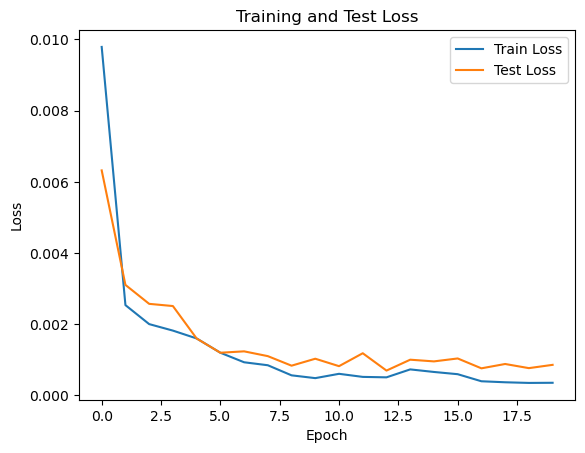

In [12]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

Loss: 0.0017
Target Joint Angles: [[  36.   -5.  -56.   -6.   -3.   55.]
 [  36.  -25. -110.   67.   -3.   80.]
 [  36.   -5.  -56.  -21.   -3.   55.]
 [ -48.   -5.  -58.  -21.   -3.   45.]
 [  15.    0.    0.    0.    0.   55.]]
Predicted Joint Angles: [[  36.   -6.  -58.   -6.   -6.   41.]
 [  35.  -28. -111.   68.   -3.   46.]
 [  34.   -4.  -54.  -21.   -3.   55.]
 [ -41.  -14.  -51.  -21.   -4.   49.]
 [  19.    0.    2.    1.   -1.   57.]]


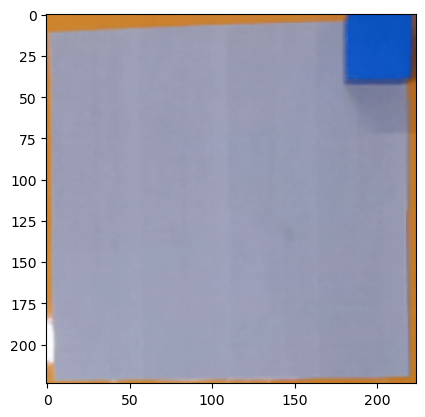

In [13]:
model.eval()
with torch.no_grad():
    image, target = test_dataset[1]
    image = image.unsqueeze(0).to(device)
    target = target.unsqueeze(0).to(device)
    output = model(image)
    loss = criterion(output, target)
    print(f"Loss: {loss.item():.4f}")

    # Convert to numpy arrays
    target = target.cpu().numpy().flatten()
    output = output.cpu().numpy().flatten()

    # Convert to matrix (5x6)

    target = np.round(target.reshape(5, 6) * 180.0)  # Convert to degrees
    output = np.round(output.reshape(5, 6) * 180.0)  # Convert to degrees

    # Print the target and predicted joint angles
    print("Target Joint Angles:", target)
    print("Predicted Joint Angles:", output)

plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0))

In [14]:
torch.save(model.state_dict(), "model/modelV0.pth")

model_test = ImageToJointAngles().to(device)
model_test.load_state_dict(torch.load("model/modelV0.pth"))

model

/var/folders/qx/m3g2_5ys4b3b7hgjbrhwgwsw0000gn/T/ipykernel_3141/1361421957.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load("model/m

ImageToJointAngles(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,